In [15]:
# Uncomment to install dependencies if needed
# !pip install yfinance seaborn

import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Define etf symbols


all_etf = {
    "Technology & Communication": ['XLK', 'VGT', 'FDN', 'IYW', 'SMH', 'XLC', 'VOX'],
    "Consumer & Healthcare": ['XLY', 'VCR', 'RCD', 'XLP', 'VDC', 'RHS', 'XLV', 'IYH', 'VHT'],
    "Finance & Real Estate": ['XLF', 'VFH', 'KBE', 'KRE', 'XLRE', 'VNQ', 'IYR'],
    "Energy, Materials & Industrials": ['XLE', 'VDE', 'XOP', 'XLB', 'VAW', 'XLI', 'VIS', 'IYJ'],
    "Global & Macro Assets": ['UUP', 'FXE', 'FXY', 'FXB', 'GLD', 'SLV', 'DBC', 'DBA', 'USO',
                              'EWA', 'EWC', 'EWG', 'EWJ', 'EWQ', 'EWU', 'EWH', 'EWT', 'EWZ']
}


In [17]:
def download_stock_data(symbols, start_date, end_date):
    """
    Downloads daily close prices for a list of stock symbols using yfinance.Ticker.history().
    Returns a DataFrame with dates as index and symbols as columns.
    """
    all_data = {}

    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            hist = ticker.history(start=start_date, end=end_date)
            if 'Close' in hist.columns and not hist['Close'].empty:
                all_data[symbol] = hist['Close']
            else:
                print(f"⚠️ No close data for {symbol}")
        except Exception as e:
            print(f"❌ Failed to download {symbol}: {e}")

    df = pd.DataFrame(all_data)
    df.index = pd.to_datetime(df.index)
    return df

In [18]:
def generate_correlation_heatmap(data):
    """
    Generates a correlation heatmap of the stock return matrix.
    """
    matrix = data.corr().round(2)
    plt.figure(figsize=(15, 10))
    sns.heatmap(matrix, cmap='RdYlGn_r', annot=True)
    plt.title("Correlation Heatmap of Stocks")
    plt.show()

In [19]:
def find_cointegrated_pairs(data, symbols, significance_level=0.10):
    """
    Performs pairwise cointegration tests across stock time series.
    Returns test statistics, p-values, cointegrated pairs (with p-values), and estimated betas.
    """
    n = len(symbols)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    beta_matrix = np.zeros((n, n))
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[symbols[i]].dropna()
            S2 = data[symbols[j]].dropna()
            # Align indices
            combined = pd.concat([S1, S2], axis=1, join='inner')
            if combined.shape[0] < 100:  # Too little data, skip
                continue
            S1, S2 = combined.iloc[:, 0], combined.iloc[:, 1]
            try:
                score, pvalue, _ = coint(S1, S2)
                model = sm.OLS(S1, sm.add_constant(S2)).fit()
                beta = model.params[1]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                beta_matrix[i, j] = beta
                if pvalue < significance_level:
                    pairs.append((symbols[i], symbols[j], pvalue))
            except Exception as e:
                print(f"Error testing pair {symbols[i]} & {symbols[j]}: {e}")
                continue

    return score_matrix, pvalue_matrix, pairs, beta_matrix

In [20]:
def plot_cointegrated_pairs_heatmap(pvalues, symbols,threshold):
    """
    Plots a heatmap of cointegration p-values, masking non-significant pairs.
    """
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        pvalues,
        xticklabels=symbols,
        yticklabels=symbols,
        cmap='RdYlGn_r',
        mask=(pvalues >= threshold),
        annot=True
    )
    plt.title("Heatmap of Cointegration p-values (< 0.10)")
    plt.show()

In [21]:
def plot_spread(data, stock1, stock2, beta):
    spread = data[stock1] - beta * data[stock2]
    moving_avg = spread.rolling(window=180).mean()
    spread.plot(title=f"Spread: {stock1} - {beta:.2f} × {stock2}", figsize=(12, 6))
    moving_avg.plot(label=f'180-day Moving Average', color='orange', linestyle='--')
    plt.axhline(spread.mean(), color='red', linestyle='--', label='Total Mean')
    plt.legend()
    plt.show()
    return spread

In [22]:
def run_group_analysis(all_groups, start_date='2018-01-01', end_date='2025-01-01', significance_level=0.1):
    all_results = []

    for group_name, tickers in all_groups.items():
        print(f"\n🔍 Processing group: {group_name}")
        try:
            data = download_stock_data(tickers, start_date, end_date)
            data = data.dropna(axis=1, how='all')
            symbols = list(data.columns)

            if len(symbols) < 2:
                print("⚠️ Not enough data to analyze this group.")
                continue

            score_matrix, pvalue_matrix, pairs, beta_matrix = find_cointegrated_pairs(data, symbols, significance_level)
            plot_cointegrated_pairs_heatmap(pvalue_matrix, symbols,threshold=0.1)

            for s1, s2, pval in pairs:
                idx1, idx2 = symbols.index(s1), symbols.index(s2)
                beta = beta_matrix[idx1, idx2]
                all_results.append({
                    's1': s1,
                    's2': s2,
                    'pval': pval,
                    'beta': beta,
                    'data': data[[s1, s2]],
                    'group': group_name
                })

        except Exception as e:
            print(f"⚠️ Error in group {group_name}: {e}")

    if not all_results:
        print("\n❌ No cointegrated pairs found in any group.")
        return

    # Sort all pairs by p-value
    top_pairs = sorted(all_results, key=lambda x: x['pval'])[:5]

    print("\n🌟 Top 5 Cointegrated Pairs Across All Groups:")
    for pair in top_pairs:
        print(f"{pair['s1']} & {pair['s2']} (Group: {pair['group']}) | p = {pair['pval']:.4f} | β = {pair['beta']:.4f}")
        spread = plot_spread(pair['data'], pair['s1'], pair['s2'], pair['beta'])
        #half_life = estimate_half_life(spread)
        #print(f"{pair['s1']} & {pair['s2']} (Group: {pair['group']}) | half life = {half_life:.2f} days")


🔍 Processing group: Technology & Communication


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

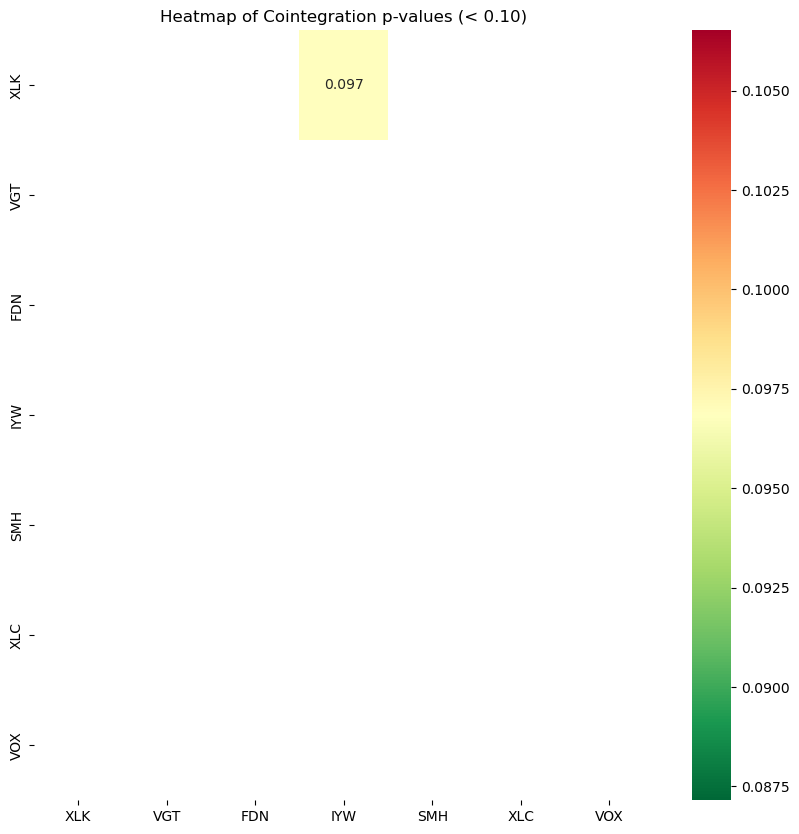


🔍 Processing group: Consumer & Healthcare


$RCD: possibly delisted; no price data found  (1d 2012-01-01 -> 2022-01-01) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1641013200")


⚠️ No close data for RCD


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

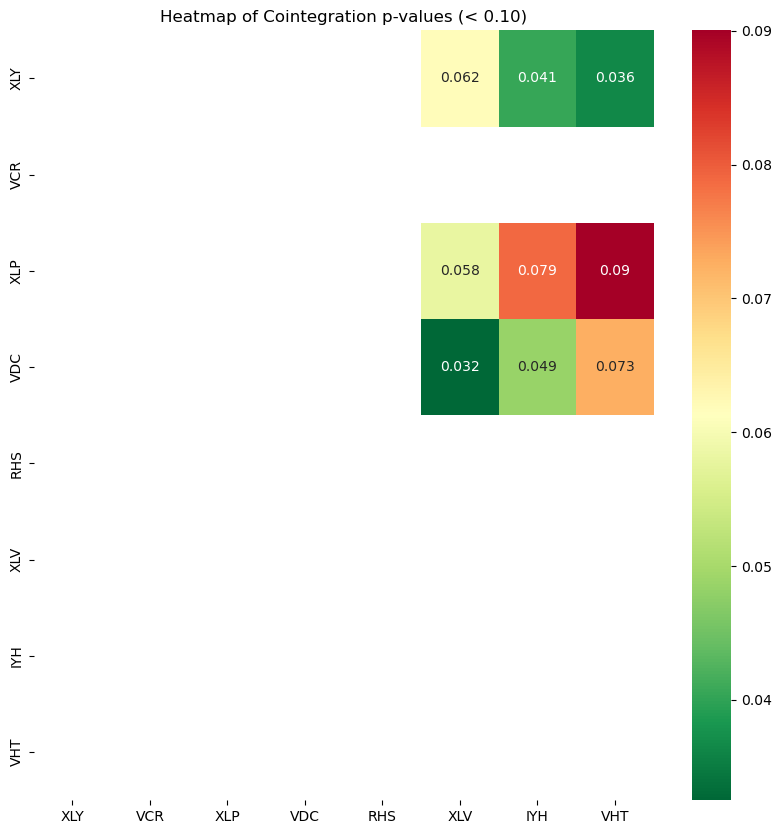


🔍 Processing group: Finance & Real Estate


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

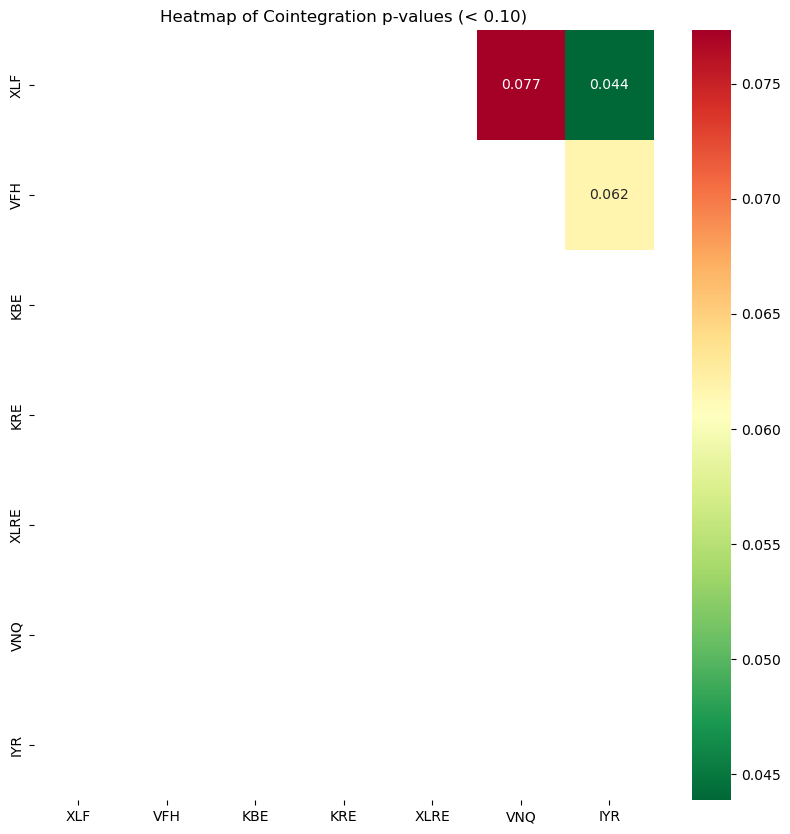


🔍 Processing group: Energy, Materials & Industrials


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

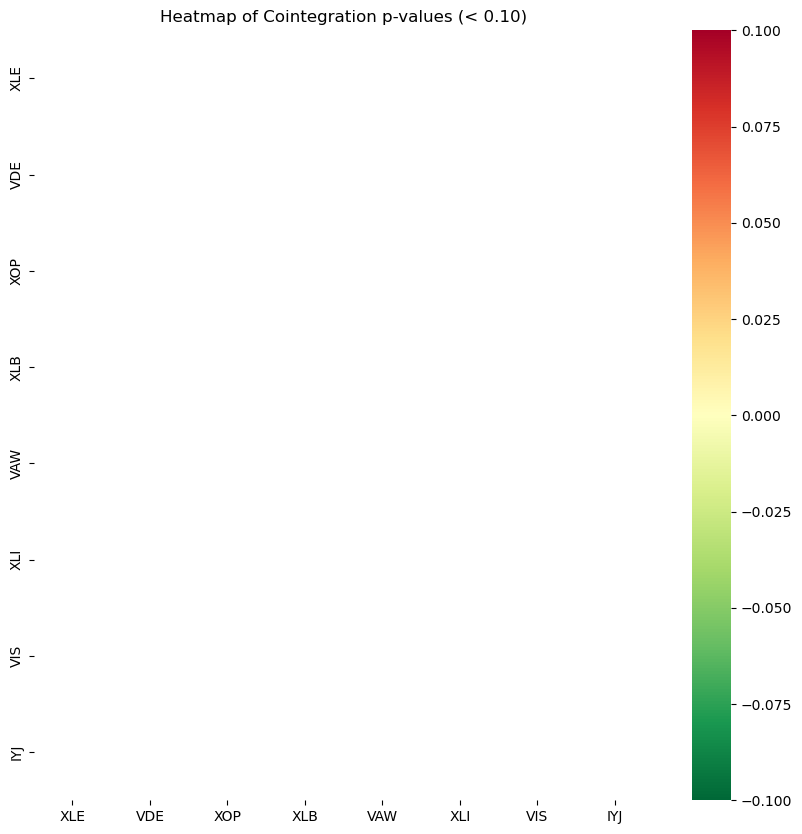


🔍 Processing group: Global & Macro Assets


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

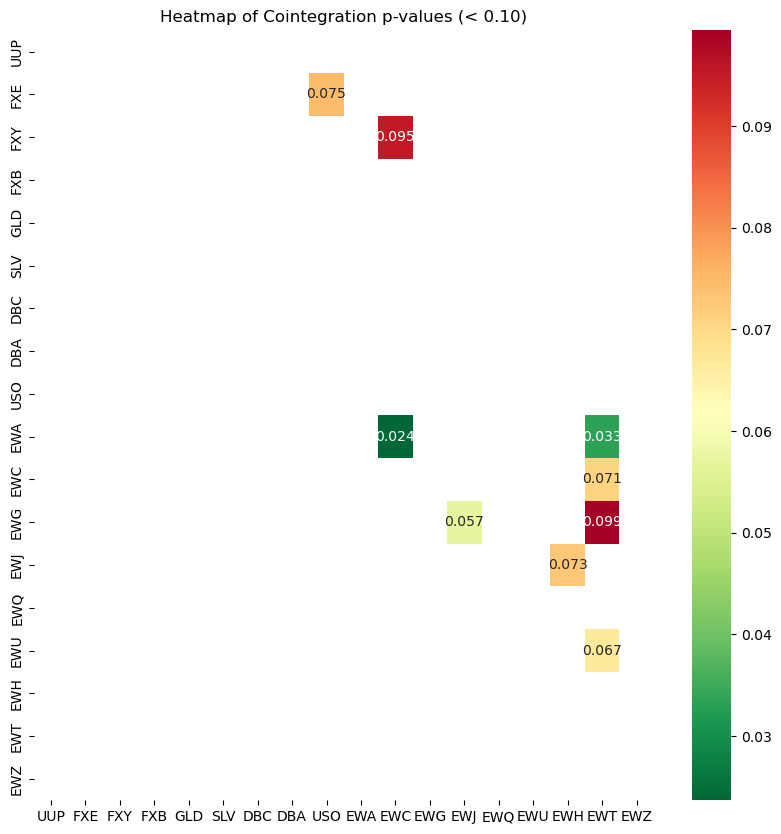


🌟 Top 5 Cointegrated Pairs Across All Groups:
EWA & EWC (Group: Global & Macro Assets) | p = 0.0237 | β = 0.6318


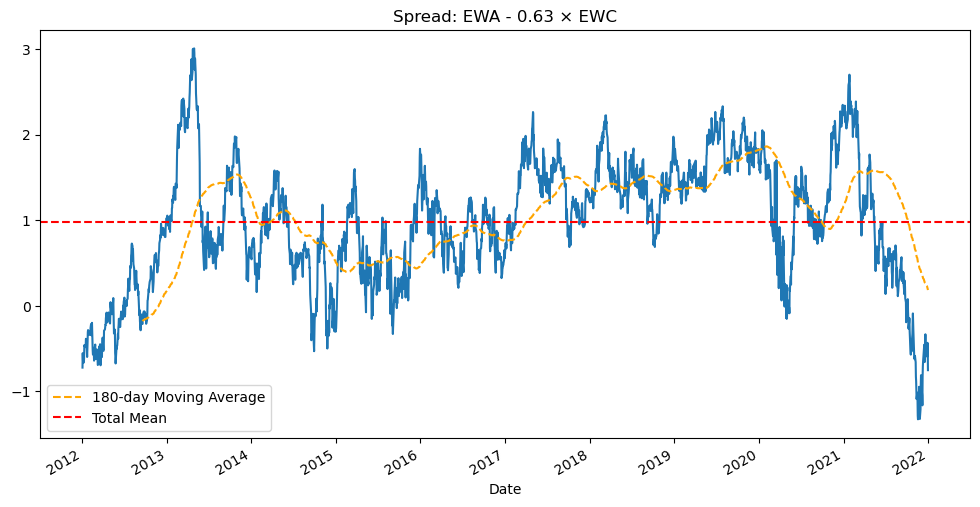

VDC & XLV (Group: Consumer & Healthcare) | p = 0.0325 | β = 1.1617


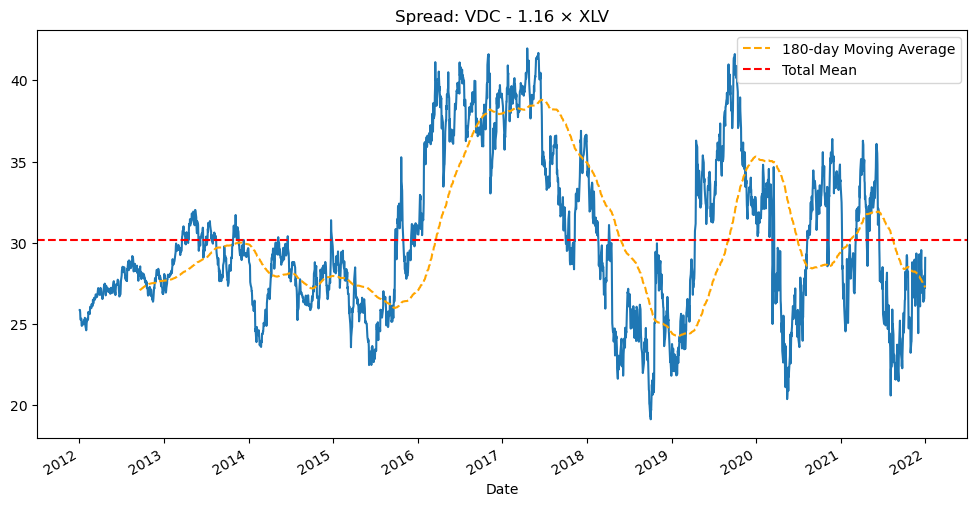

EWA & EWT (Group: Global & Macro Assets) | p = 0.0334 | β = 0.2733


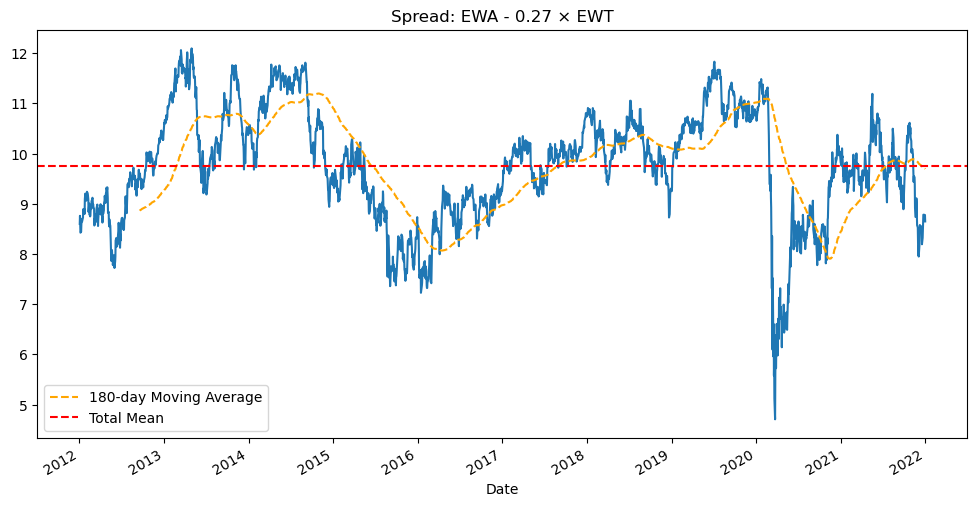

XLY & VHT (Group: Consumer & Healthcare) | p = 0.0364 | β = 0.7864


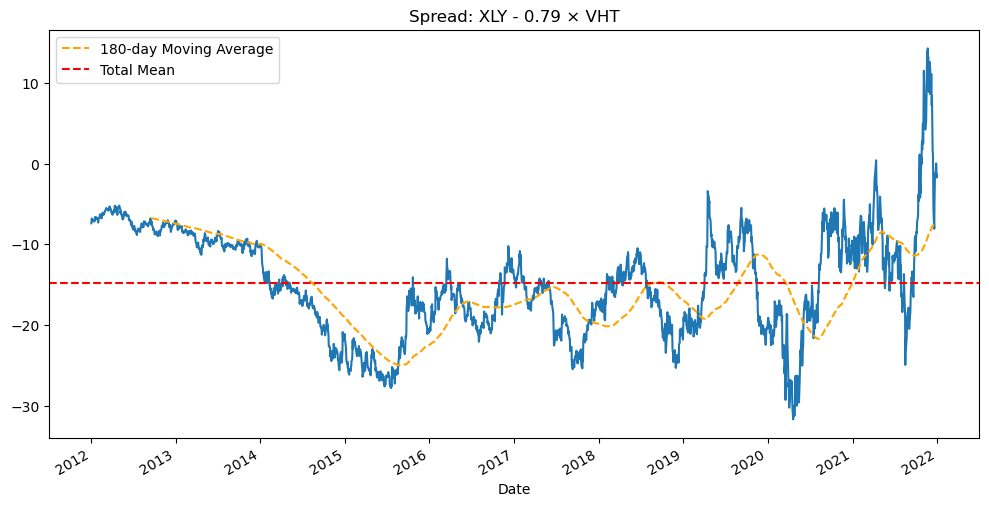

XLY & IYH (Group: Consumer & Healthcare) | p = 0.0406 | β = 3.5458


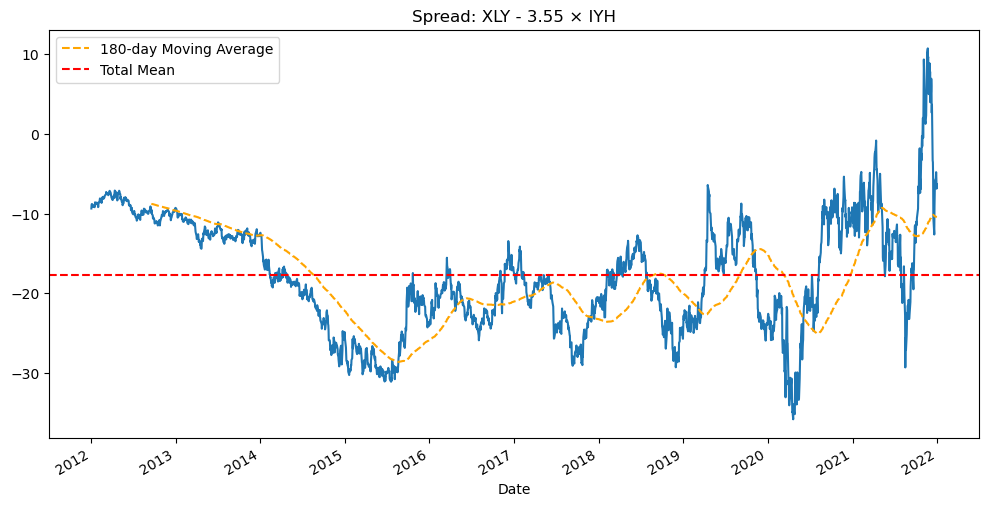

In [23]:
# Run the full analysis
if __name__ == "__main__":
    run_group_analysis(all_etf,start_date='2012-01-01', end_date='2022-01-01')

In [24]:
group_financials = ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'USB', 'PNC', 'TFC', 'SCHW']
group_big_tech = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'ADBE', 'CRM', 'INTC']
group_healthcare = ['JNJ', 'PFE', 'MRK', 'LLY', 'UNH', 'BMY', 'AMGN', 'GILD', 'MDT', 'ABBV']
group_energy_stocks = ['XOM', 'CVX', 'COP', 'EOG', 'PSX', 'MPC', 'SLB', 'HAL', 'VLO', 'BKR']
group_consumer = ['WMT', 'COST', 'TGT', 'HD', 'LOW', 'MCD', 'SBUX', 'PG', 'KO', 'PEP']
group_industrials = [
    'UNP',   # Union Pacific
    'CSX',   # CSX Corporation
    'NSC',   # Norfolk Southern
    'FDX',   # FedEx
    'UPS',   # United Parcel Service
    'CAT',   # Caterpillar
    'DE',    # Deere & Company
    'GE',    # General Electric
    'LMT',   # Lockheed Martin
    'RTX',   # RTX Corporation
    'BA',    # Boeing
    'HON',   # Honeywell
    'MMM',   # 3M
    'ETN',   # Eaton
    'EMR'    # Emerson Electric
]



In [25]:
all_stocks = {
    "Tech Mega Caps": group_big_tech,
    "Financials": group_financials,
    "Healthcare": group_healthcare,
    "Energy & Materials": group_energy_stocks,
    "Consumer Sector": group_consumer,
    "Industrials & Transportation": group_industrials
}



🔍 Processing group: Tech Mega Caps


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

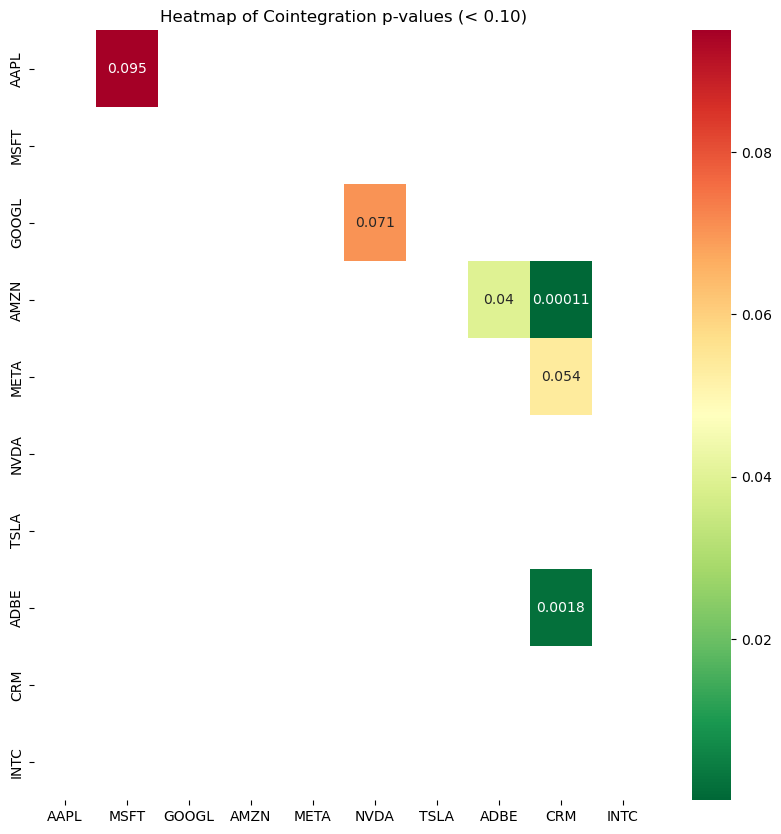


🔍 Processing group: Financials


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

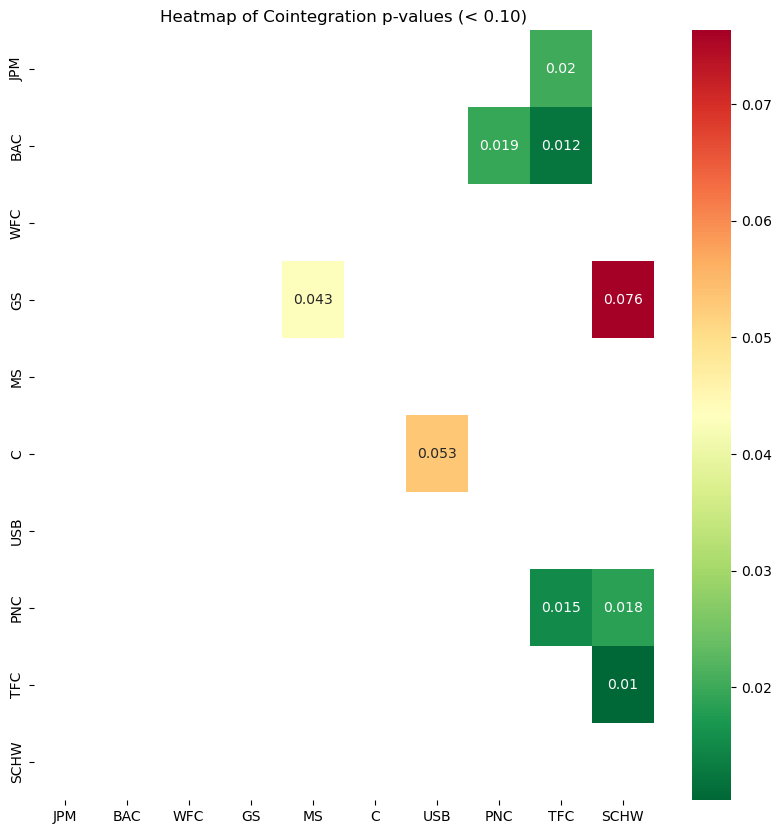


🔍 Processing group: Healthcare


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

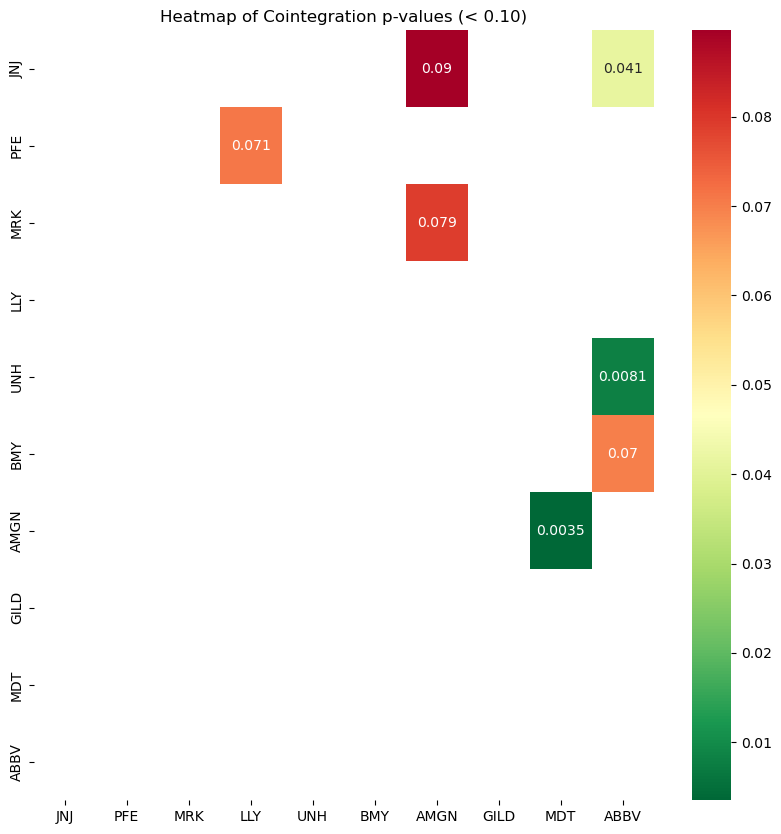


🔍 Processing group: Energy & Materials


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

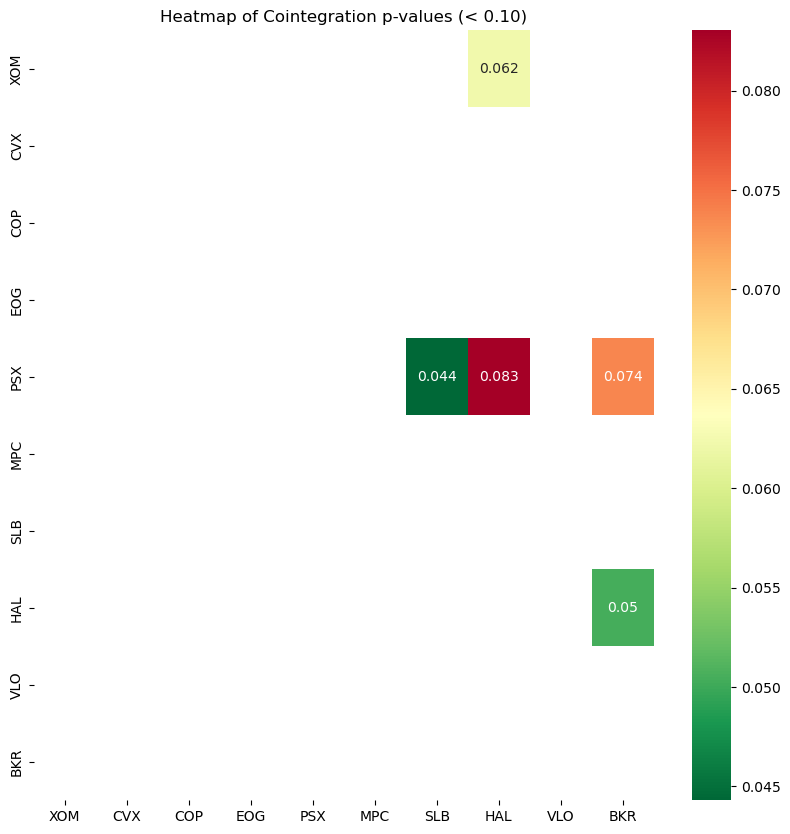


🔍 Processing group: Consumer Sector


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

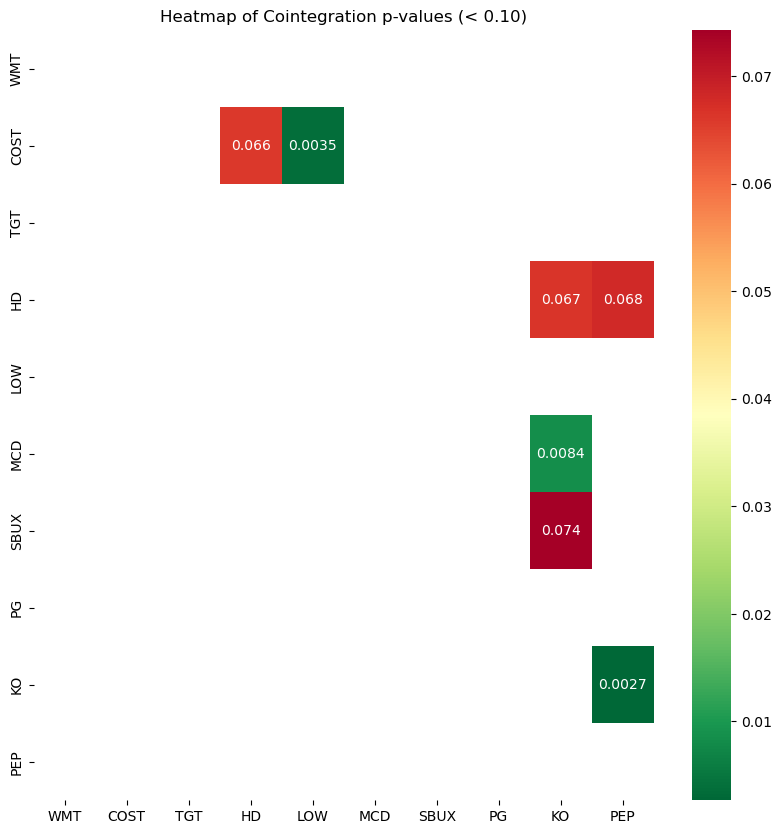


🔍 Processing group: Industrials & Transportation


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25824\2139474766.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\LENOVO\AppDat

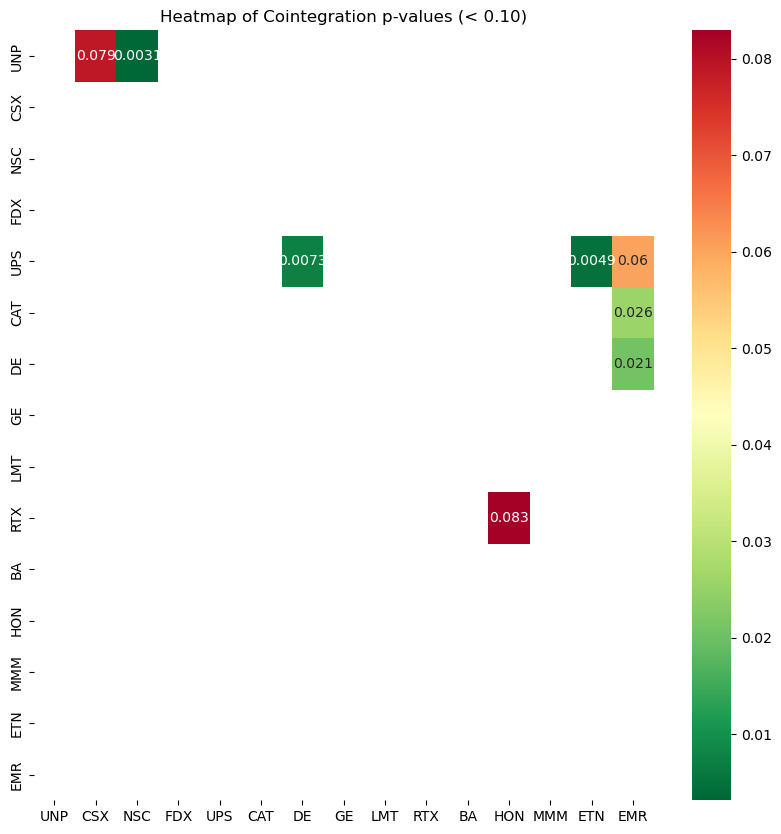


🌟 Top 5 Cointegrated Pairs Across All Groups:
AMZN & CRM (Group: Tech Mega Caps) | p = 0.0001 | β = 0.7542


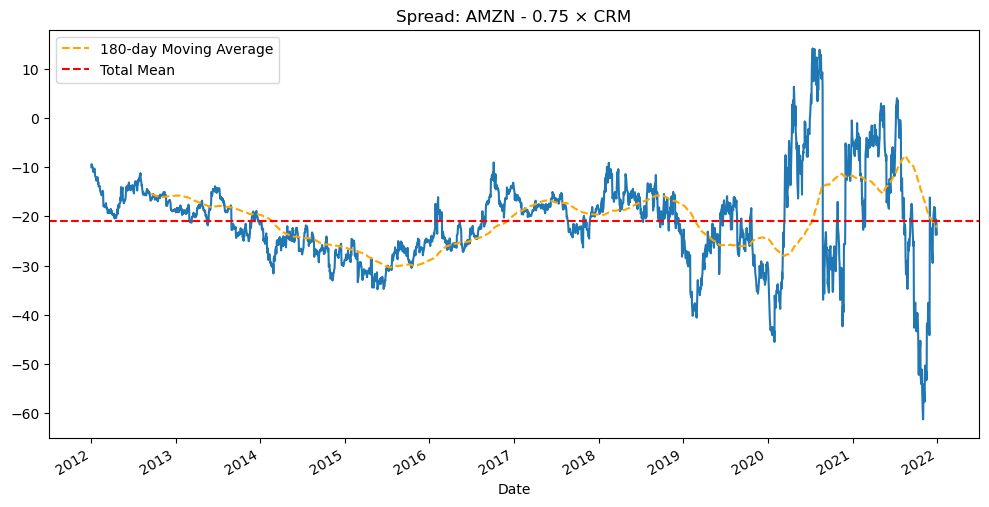

ADBE & CRM (Group: Tech Mega Caps) | p = 0.0018 | β = 2.4604


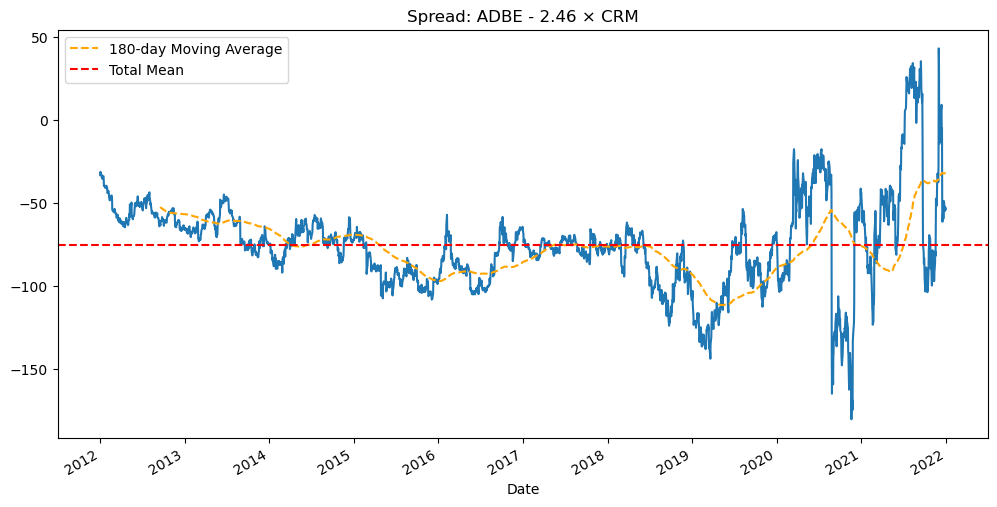

KO & PEP (Group: Consumer Sector) | p = 0.0027 | β = 0.2731


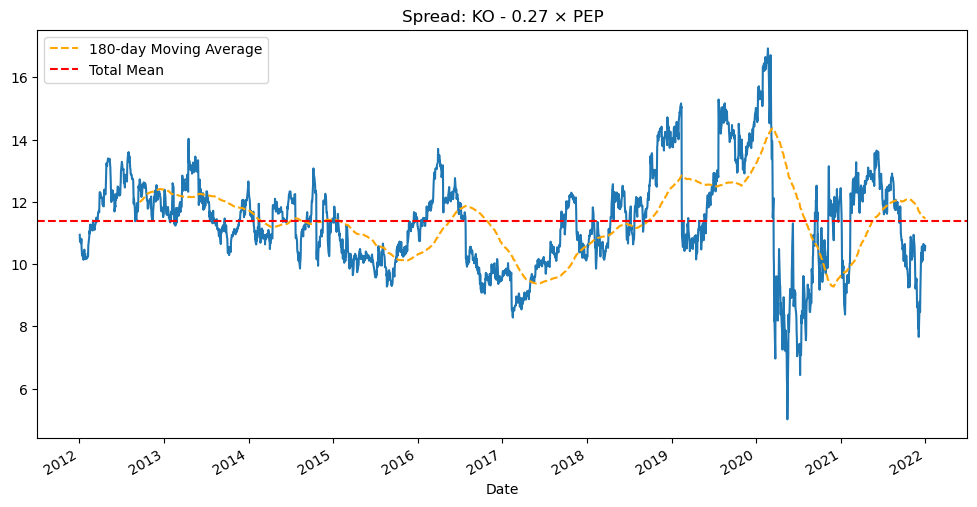

UNP & NSC (Group: Industrials & Transportation) | p = 0.0031 | β = 0.8031


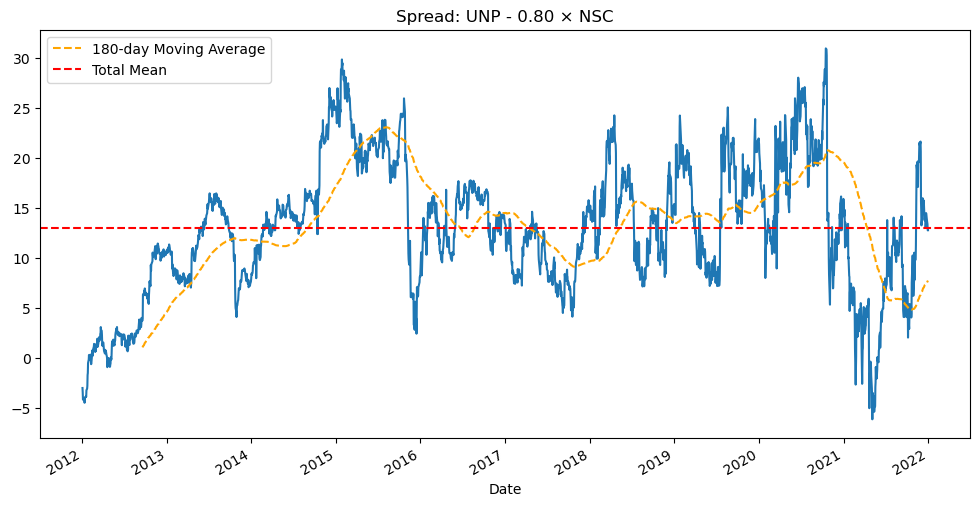

AMGN & MDT (Group: Healthcare) | p = 0.0035 | β = 1.9913


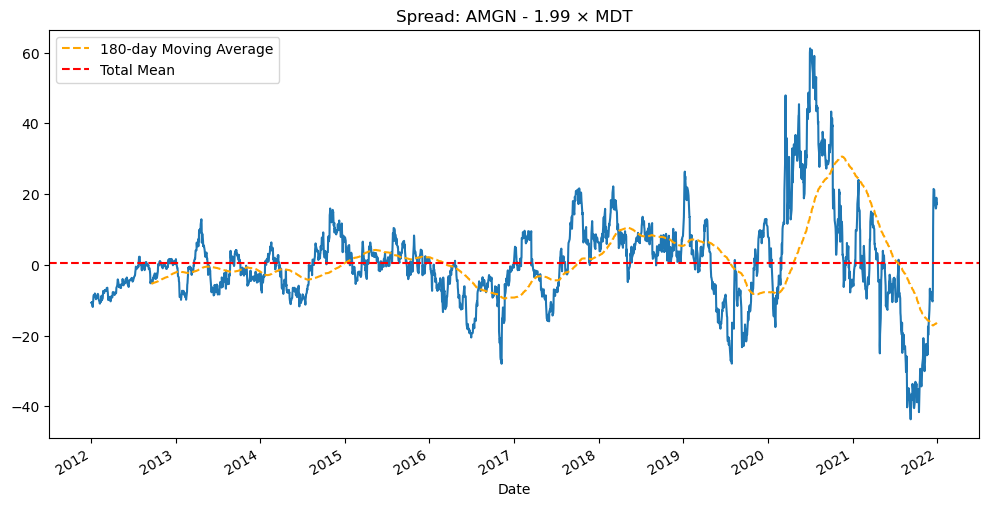

In [26]:
if __name__ == "__main__":
    run_group_analysis(all_stocks,start_date='2012-01-01', end_date='2022-01-01')

In [27]:
# 设置股票代码和日期范围
tickers = ['KO', 'PEP']
start_date = '2012-01-01'
end_date = '2025-01-01'

# 下载收盘价数据
data = yf.download(tickers, start=start_date, end=end_date)

# 保存到本地 CSV 文件
data.to_csv('KO_PEP_close_2012_2025.csv')

[*********************100%***********************]  2 of 2 completed


In [28]:
tickers_etf = ['VDC', 'XLV']

# 下载收盘价数据
data = yf.download(tickers_etf, start=start_date, end=end_date)

# 保存到本地 CSV 文件
data.to_csv('etf_2012_2025.csv')

[*********************100%***********************]  2 of 2 completed
